# Image Classification: Pistachios

## MIDS W281: Computer Vision, Summer 2022

### Team members: Blake Bormes, Yu (Albert) Jiang, Deva Kulkarni

## Introduction

The focus of this project is to apply various computer vision techniques to classify images of pistachios. The dataset used in this project is made available on kaggle.com[1]. This dataset contains a total of 2148 images of two major types of pistachios grown in turkey, namely Kirmizi and Siirt. Since the prices, tastes, and nutritional values of these types differs, the type of pistachio becomes important when it comes to trade[2]. The dataset includes 1232 images of Kirmizi pistachios and 916 of Siirt Pistachios. 

The following report describes the Exploratory Data Analysis, Feature Extraction, Principal Component Analysis and Classification steps performed through the course of this project.



## Imports

In [12]:
#Importing libraries

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import seaborn as sns
from scipy.cluster.vq import vq

## Load data

In [2]:
# csv file with pistachio names and labels
csv = pd.read_csv('pistachios_initial.csv', index_col = 0)

In [3]:
# pistachio_type 1 is Kirmizi, pistachio_type 0 is Siirt
csv.head()

,filename,filename_camelcase,pistachio_type
0,kirmizi (23).jpg,kirmizi_23.jpg,0
1,kirmizi 21.jpg,kirmizi_21.jpg,0
2,kirmizi 35.jpg,kirmizi_35.jpg,0
3,kirmizi 475.jpg,kirmizi_475.jpg,0
4,kirmizi 313.jpg,kirmizi_313.jpg,0


In [4]:
csv.pistachio_type.value_counts()

0    1232
1     916
Name: pistachio_type, dtype: int64

In [5]:
images = [] #list of images

for fname in csv.filename.values:
    if "kirm" in fname:
        fname = "Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio/{}".format(fname)
    else:
        fname = "Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio/{}".format(fname)
        
    images.append(plt.imread(fname))


print('Total number of images: {}'.format(len(images)))
print('Shape of each image: {}'.format(images[0].shape))

Total number of images: 2148
Shape of each image: (600, 600, 3)


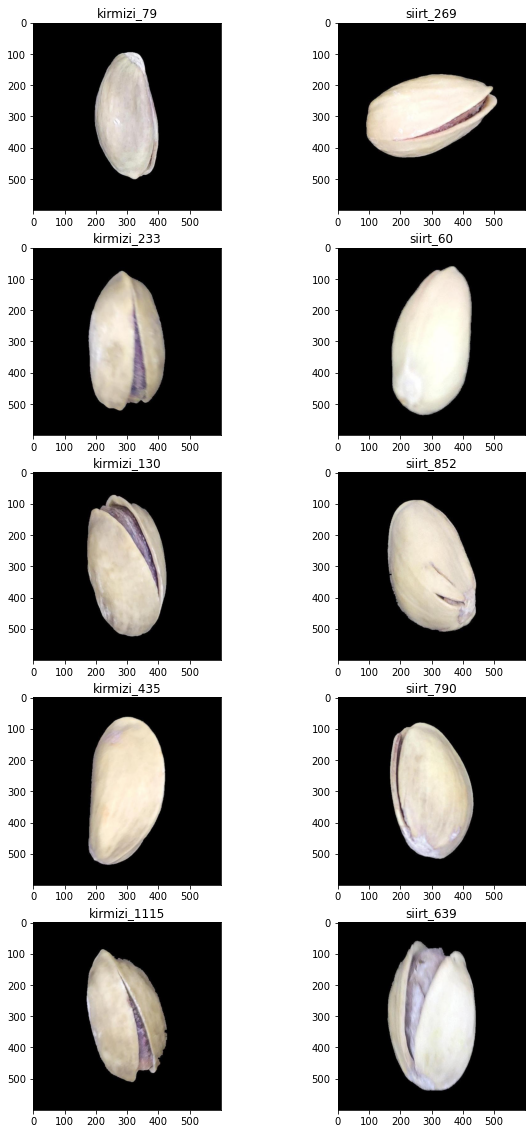

In [7]:
#Create list of random indexes to display random images
low = csv.pistachio_type.value_counts()[0]
high = csv.pistachio_type.value_counts()[1]
random.seed(123)
random_image_index_kirmizi = np.random.randint(low, size=5)
random_image_index_siirt = np.random.randint(low + 1, low + high +1, size=5)


# Display examples images
fig, ax = plt.subplots(len(random_image_index_kirmizi),2, figsize = (10, 20))

for j, (index_0, index_1) in enumerate(zip(random_image_index_kirmizi, random_image_index_siirt)):
    
    ax[j, 0].imshow(images[index_0])
    ax[j, 0].set_title(csv.filename_camelcase[index_0][:-4])
    
    ax[j, 1].imshow(images[index_1])
    ax[j, 1].set_title(csv.filename_camelcase[index_1][:-4])      
        

## EDA and Feature Extraction

- We look at the percentage of the image covered by the pistachio. We see that there is some separation between the two classes for this variable.

In [8]:
# Convert images to grayscale, and calculate the percentage area covered by the pistachio
grey_images = []
for img in images:
    grey_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

percent_area = []
for img in grey_images:
    percent_area.append(np.count_nonzero(img)/(img.shape[0]*img.shape[1]))

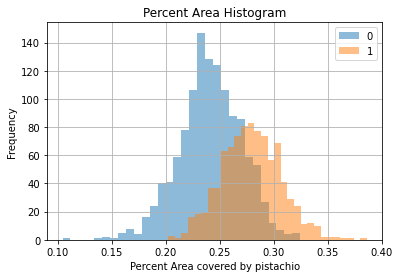

In [9]:
# Plot percent area for the two labels
csv['percent_area'] = percent_area

plt.hist(csv[csv.pistachio_type == 0].percent_area, bins = 30, alpha = 0.5, label = 0)
plt.hist(csv[csv.pistachio_type == 1].percent_area, bins = 30, alpha = 0.5, label = 1)
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Percent Area covered by pistachio')
plt.ylabel('Frequency')
plt.title('Percent Area Histogram')
plt.show()

- We fit an ellipse to the outer edges of the pistachio image. Using the fitted ellipse, we calculate the major axis, minor axis, area and perimeter. We further use these parameters to calculate eccentricity, equivalent diameter, extent, aspect ratio, compactness, roundness and four shape factors as defined below

***Add definitions of variables***

***Add code for fitting ellipse***

***Show sample images with pisatchio and fitted ellipse and major/minor axes***

***Maybe some plots showing distributions of some of the variables between the two classes?***

- To quantify the fit of the ellipse to the outer edges of the pisatchio, we calculate the distance of each point on the pistachio edge from the fitted ellipse. The final feature is the sum of all the distances for each pistachio scaled by the perimeter of the ellipse.

In [14]:
#Rescale and blur
rescaled_images = []
for img in grey_images:
    rescaled_images.append(cv2.GaussianBlur(cv2.resize(img, (200, 200)), (9, 9), 0))

def fit_ellipse(img):
    '''This function takes in an image of a pistachio and fits an ellipse to its outer edges.
    '''
    out_img = img.copy()            
    
    try:
        
        ret,thresh = cv2.threshold(out_img,5,255,0)
        contours,hierarchy = cv2.findContours(thresh, 1, 2)
        
        cnt = contours[-1]
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt,True)
        ellipse = cv2.fitEllipse(cnt)
        return cv2.ellipse(out_img,ellipse,(255),2), cv2.ellipse(np.zeros_like(out_img),ellipse,(255),1), ellipse

    except cv2.error as e:
        pass

#Fit ellipse
ellipse_images = []
for img in rescaled_images:
    ellipse_images.append(fit_ellipse(img))
    
    
#Detect edges
def whiten_image(img):
    '''Take a rescaled and blurred image of pistachio, blow up pistachio to white,
    detect edges and return.
    '''    
    out_img = img.copy()
    
    out_img = np.where(out_img > 5, 255, 0).astype('uint8')
    
    return cv2.Canny(out_img, 100, 200)


white_patch_edge_detect = []
for img in rescaled_images:
    white_patch_edge_detect.append(whiten_image(img))


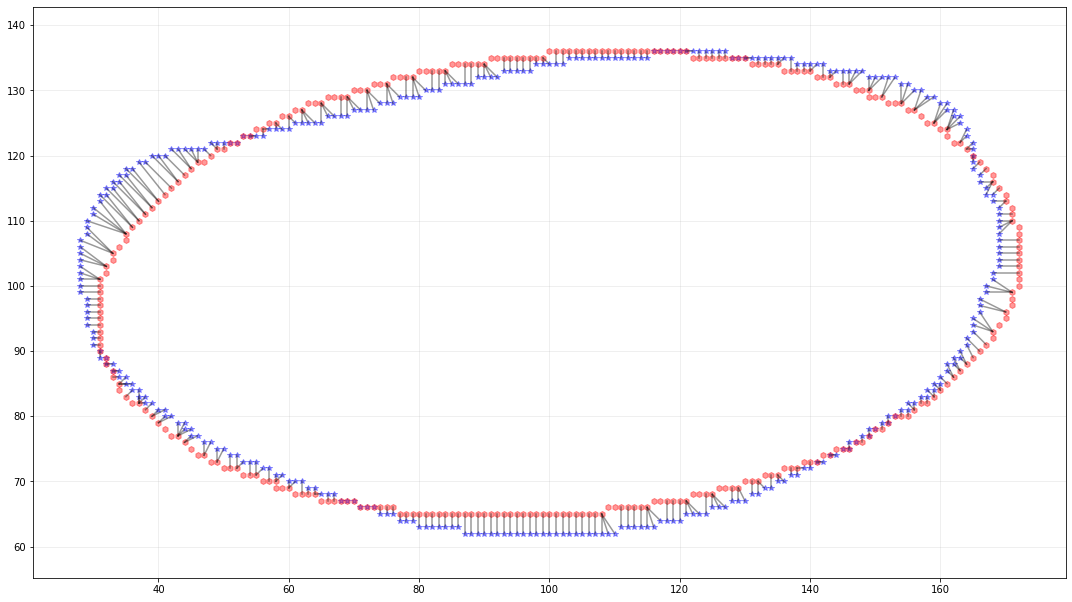

In [15]:
# Detect pistachio edge
pistachio_edge = np.argwhere(white_patch_edge_detect[random_image_index_kirmizi[0]] == 255)

# Detect ellipse 
ellipse_boundary = np.argwhere(ellipse_images[random_image_index_kirmizi[0]][1] == 255)

# For each point in pistachio_edge, find the closest point in ellipse_boundary:
code, dist = vq(pistachio_edge, points2)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(pistachio_edge[:,0], pistachio_edge[:,1], 'b*', markersize=6, alpha=0.4)
plt.plot(ellipse_boundary[:,0], ellipse_boundary[:,1], 'rh', markersize=6, alpha=0.4)

for i, j in enumerate(code):
    plt.plot([pistachio_edge[i,0], ellipse_boundary[j,0]],
             [pistachio_edge[i,1], ellipse_boundary[j,1]], 'k', alpha=0.4)

plt.grid(True, alpha=0.25)
plt.axis('equal')
plt.show()

In [16]:
def calculate_distance(ellipse_img, edge_img):
    '''This function calcualtes the minimum distance between points on 
    the edge image and points on the ellipse image. Returns total disstance normalized by ellipse perimeter
    '''
    edge_points = np.argwhere(edge_img == 255)
    ellipse_points = np.argwhere(ellipse_img[1] == 255)
    
       
    code, dist = vq(edge_points, ellipse_points)
    
    return dist.sum()/calculate_perimeter(ellipse_img[2][1][0], ellipse_img[2][1][1])
    
def calculate_perimeter(a,b):
    perimeter = np.pi * ( 3*(a+b) - np.sqrt( (3*a + b) * (a + 3*b) ) )
    return perimeter

In [17]:
distance_from_ellipse = []
for i in range(len(images)):
    try:
        distance_from_ellipse.append(calculate_distance(ellipse_images[i], white_patch_edge_detect[i]))
    except:
        print(i)
        distance_from_ellipse.append(np.nan)

In [18]:
csv['distance_from_ellipse'] = distance_from_ellipse

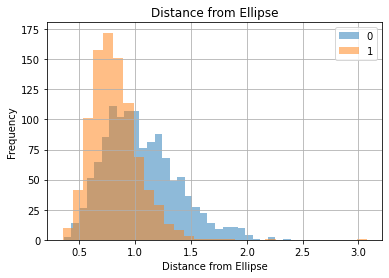

In [19]:
plt.hist(csv[csv.pistachio_type == 0].distance_from_ellipse, bins = 30, alpha = 0.5, label = 0)
plt.hist(csv[csv.pistachio_type == 1].distance_from_ellipse, bins = 30, alpha = 0.5, label = 1)
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Distance from Ellipse')
plt.ylabel('Frequency')
plt.title('Distance from Ellipse')
plt.show()

We see that the distance of ellipse parameter does show some separation between the two classes.

- We also look at the color data from each image. Specifically, we calculate the mean and median values for the pixels that depict the pistachio. We also calculate the mean and median value for each channel of the pistachio. In addition, we use k means clustering to separate the pixels into clusters that depict the pistachio shell and the pistachio nut and take the mean and median values for those

***Add code and plots showing color stuff**

### PCA analysis

### Learned features

### Classification

### Discussion

### Conclusions and Future work(?)

## References

[1] Pistachio Image Dataset https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset

[2] SINGH D, TASPINAR YS, KURSUN R, CINAR I, KOKLU M, OZKAN IA, LEE H-N., (2022). Classification and Analysis of Pistachio Species with Pre-Trained Deep Learning Models, Electronics, 11 (7), 981. https://doi.org/10.3390/electronics11070981. (Open Access)